line_loading_0     22.651661
line_loading_1     22.651661
line_loading_2     21.153523
line_loading_3     15.346448
line_loading_4     15.346448
line_loading_5      9.234811
line_loading_6      9.234811
line_loading_7      9.234811
line_loading_8      5.394322
line_loading_9      1.498138
line_loading_10     5.807178
line_loading_11     5.807178
line_loading_12     5.807178
line_loading_13     5.807178
line_loading_14     6.111643
line_loading_15     3.840489
line_loading_16     5.394322
line_power_0        0.147686
line_power_1        0.146813
line_power_2        0.136286
line_power_3        0.098262
line_power_4        0.097861
line_power_5        0.058634
line_power_6        0.058489
line_power_7        0.058344
line_power_8        0.033996
line_power_9        0.009654
line_power_10       0.037263
line_power_11       0.036972
line_power_12       0.036681
line_power_13       0.036390
line_power_14       0.038826
line_power_15       0.024203
line_power_16       0.033947
trafo_loading_

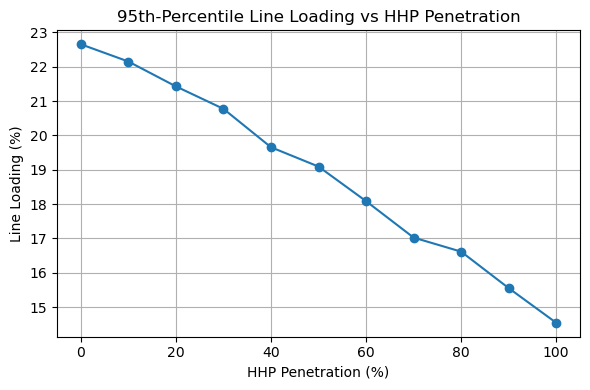

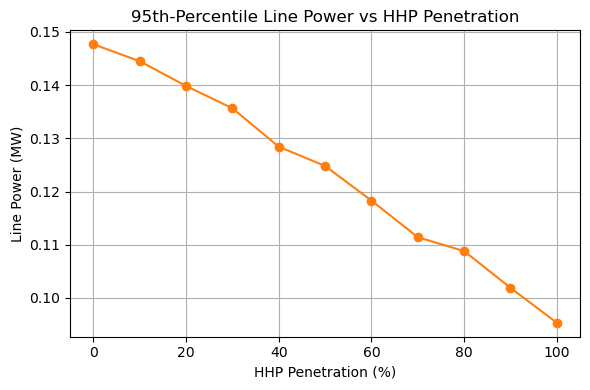

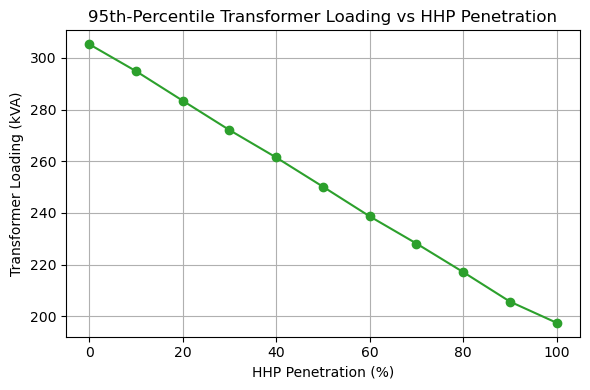

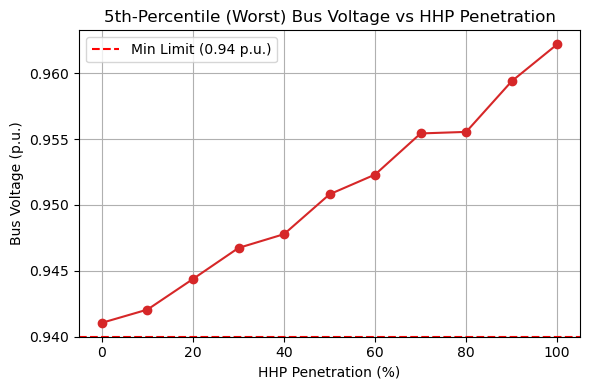

In [4]:
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt

# 1) Find all your Monte Carlo result files
#    assuming they live in ./output/ and are named like "..._HHP_20p_100samples.csv"
files = glob.glob(r"E:\GitHubProjects\LV network\Codes\Output\Base_with_powerfactor095\montecarlo_results_HHP_*p_*samples.csv")

records = []
n=0
for fn in files:
    # 2) Extract HHP penetration from filename, handles e.g. "..._HHP_70p_10samples.csv"
    m = re.search(r"_HHP_(\d{1,3})p_", fn)
    if not m:
        continue
    perc = int(m.group(1)) / 100.0

    # 3) Load data
    df = pd.read_csv(fn)
    df = df.loc[:, ~df.columns.str.contains("time", case=False)]
    # 4) Compute 95th percentile per column
    pct95 = df.quantile(0.95)
    pct05 = df.quantile(0.05)
    while n==0:
        print(pct95)
        n += 2
    # 5) Collapse metrics
    line_loading_95 = pct95.filter(like="line_loading_").max()
    line_power_95   = pct95.filter(like="line_power_").max()
    trafo_loading_95 = pct95.filter(like="trafo_loading_").max()
    bus_voltage_05  = pct05.filter(like="bus_voltage_").min()

    records.append({
        "hhp_pct": perc * 100,
        "line_loading_95": line_loading_95,
        "line_power_95": line_power_95,
        "trafo_loading_95": trafo_loading_95,
        "bus_voltage_05": bus_voltage_05
    })

# 6) Build DataFrame
df_results = pd.DataFrame(records).sort_values("hhp_pct").set_index("hhp_pct")

# 7) Plot

# assume df_results is already built and indexed by hhp_pct

# 1) Line Loading (%)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["line_loading_95"], marker='o')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Line Loading (%)")
plt.title("95th‐Percentile Line Loading vs HHP Penetration")
plt.grid(True)
plt.tight_layout()

# 2) Line Power (MW)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["line_power_95"], marker='o', color='C1')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Line Power (MW)")
plt.title("95th‐Percentile Line Power vs HHP Penetration")
plt.grid(True)
plt.tight_layout()

# 3) Transformer Loading (%)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["trafo_loading_95"]*0.5*1000/100, marker='o', color='C2')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Transformer Loading (kVA)")
plt.title("95th‐Percentile Transformer Loading vs HHP Penetration")
plt.grid(True)
plt.tight_layout()

# 4) Worst‐Case Bus Voltage (p.u.)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["bus_voltage_05"], marker='o', color='C3')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Bus Voltage (p.u.)")
plt.title("5th‐Percentile (Worst) Bus Voltage vs HHP Penetration")
plt.axhline(0.94, color='red', linestyle='--', label='Min Limit (0.94 p.u.)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



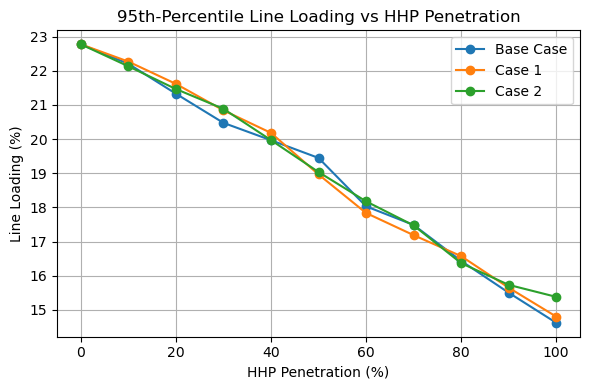

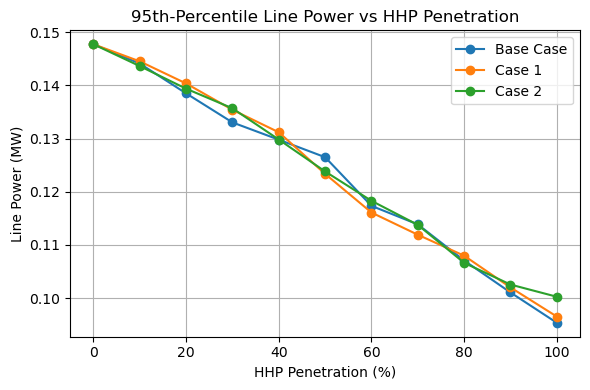

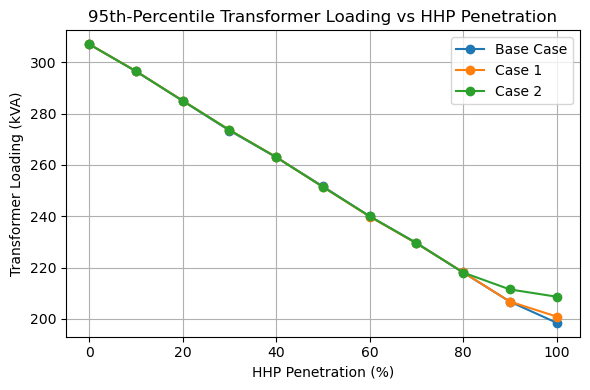

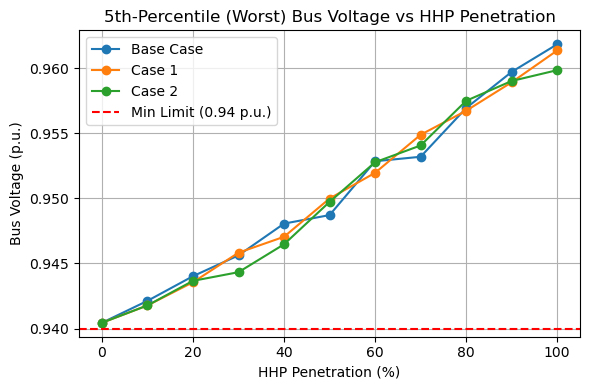

In [8]:
import re, glob
import pandas as pd
import matplotlib.pyplot as plt

# 0) Define your scenarios
cases = {
    # "Base Case":    r"E:\GitHubProjects\LV network\Codes\Output\Base Case",
    # "Case 1":       r"E:\GitHubProjects\LV network\Codes\Output\Case Low Tol",
    # "Case 2":       r"E:\GitHubProjects\LV network\Codes\Output\Case Cold Spell",
    "Base Case":       r"E:\GitHubProjects\LV network\Codes\Output\Base Case_095",
    "Case 1":       r"E:\GitHubProjects\LV network\Codes\Output\Case Low Tol_095",
    "Case 2":       r"E:\GitHubProjects\LV network\Codes\Output\Case Cold Spell_095",
}

# 1) helper to build df_results for one folder
def load_results_from(folder):
    files = glob.glob(f"{folder}/montecarlo_results_HHP_*p_*samples.csv")
    records = []
    for fn in files:
        m = re.search(r"_HHP_(\d{1,3})p_", fn)
        if not m: 
            continue
        perc = int(m.group(1)) / 100.0

        df = pd.read_csv(fn)
        # drop any “time” cols
        df = df.loc[:, ~df.columns.str.contains("time", case=False)]

        pct95 = df.quantile(0.95)
        pct05 = df.quantile(0.05)

        records.append({
            "hhp_pct":        perc * 100,
            "line_loading_95": pct95.filter(like="line_loading_").max(),
            "line_power_95":   pct95.filter(like="line_power_").max(),
            "trafo_loading_95":pct95.filter(like="trafo_loading_").max(),
            "bus_voltage_05":  pct05.filter(like="bus_voltage_").min(),
        })

    return (
        pd.DataFrame(records)
          .sort_values("hhp_pct")
          .set_index("hhp_pct")
    )

# 2) Load all scenarios
all_results = {name: load_results_from(path)
               for name, path in cases.items()}


# 3) Plot each metric across all cases
metrics = [
    ("line_loading_95",    "Line Loading (%)", 
        "95th-Percentile Line Loading vs HHP Penetration"),
    ("line_power_95",      "Line Power (MW)",
        "95th-Percentile Line Power vs HHP Penetration"),
    ("trafo_loading_95",   "Transformer Loading (kVA)",
        "95th-Percentile Transformer Loading vs HHP Penetration",
        lambda x: x * 0.5*1000/100  # if you still need that conversion
    ),
    ("bus_voltage_05",     "Bus Voltage (p.u.)",
        "5th-Percentile (Worst) Bus Voltage vs HHP Penetration")
]

for metric, ylabel, title, *maybe_transform in metrics:
    plt.figure(figsize=(6,4))
    for case, df in all_results.items():
        series = df[metric]
        if maybe_transform:
            series = maybe_transform[0](series)
        plt.plot(df.index, series, marker='o', label=case)
    plt.xlabel("HHP Penetration (%)")
    plt.ylabel(ylabel)
    plt.title(title)
    if metric == "bus_voltage_05":
        plt.axhline(0.94, color='red', linestyle='--', label='Min Limit (0.94 p.u.)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

plt.show()

In [2]:

print(all_results)

{'Base Case':          line_loading_95  line_power_95  trafo_loading_95  bus_voltage_05
hhp_pct                                                                  
0.0            23.821273       0.148265         64.134752        0.936162
10.0           23.384906       0.145085         62.325566        0.936846
20.0           22.756607       0.140470         60.346374        0.938765
30.0           22.192607       0.136298         58.395669        0.940779
40.0           21.231012       0.129110         56.581768        0.941435
50.0           20.752212       0.125513         54.668296        0.944081
60.0           19.898620       0.119036         52.741010        0.945214
70.0           19.010025       0.112186         50.991185        0.947924
80.0           18.672227       0.109572         49.179904        0.947777
90.0           17.800392       0.102704         47.324512        0.951181
100.0          16.984931       0.096154         46.006608        0.953659, 'Case 1':          line